# Module imports

In [1]:
import pathlib
import json, csv

import numpy as np
import pandas as pd

import re

In [2]:
from IPython.display import display, HTML

In [3]:
from scipy import stats

import matplotlib.pyplot as plt

In [4]:
import seaborn as sns
sns.set_style("whitegrid")

In [5]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats import anova
from statsmodels.graphics.factorplots import interaction_plot

# Load data files

In [6]:
data_files = [x for x in pathlib.Path('./data/mazeexperiment/participant_data/').glob('*.csv') if x.stat().st_size > 1000]
print('Number of data files loaded: ', len(data_files))

Number of data files loaded:  20


## Reprocess data files

Unescaped double quotes in the `all_runtime` column causes the data files to be misparsed. This section fixes that error to make these files parseable

In [7]:
pathlib.Path('./data/mazeexperiment/escaped_participant_data/').mkdir(exist_ok=True)
for data_file in data_files:
    fixed_name = './data/mazeexperiment/escaped_participant_data/{}'.format(data_file.name)
    m = re.search(
        '(?P<directory>\./data/mazeexperiment/escaped_participant_data/)' +
        '(?P<basename>RPACR_\d{3}_\d{4}-\d{2}-\d{2})' +
        '(?P<subscript>_\d+)?' +
        '(?P<extension>\.\w+)', fixed_name)
    m = m.groupdict()
    fixed_name = '{}{}{}'.format(m['directory'], m['basename'], m['extension'])
    fixed_file = pathlib.Path(fixed_name)
    
    with data_file.open('r', encoding='utf-8') as in_file, fixed_file.open('w', encoding='utf-8') as out_file:

        # Loop through each line, fix the unescaped double quote, and write the line to a new file
        count = 0
        for line in in_file:
            if count == 0:
                out_file.writelines(line)
                continue
                
            fixed_line = line.replace('systemPlatform\': "windowsversion', 'systemPlatform\': ""windowsversion')
            fixed_line = fixed_line.replace('\')", \'experi', '\')"", \'experi')
            out_file.writelines(fixed_line)


## Reload escaped data files

In [8]:
data_files = [x for x in pathlib.Path('./data/mazeexperiment/escaped_participant_data/').glob('*.csv') if x.stat().st_size > 1000]
print('Number of data files loaded: ', len(data_files))

Number of data files loaded:  20


## Parse CSV (with correction)

In [9]:
pathlib.Path('./data/mazeexperiment/reprocessed_participant_data/').mkdir(exist_ok=True)
for data_file in data_files:
    with data_file.open('r', encoding='utf-8') as f:
        csvreader = csv.reader(f, delimiter=',', quotechar='"')
        data = []
        
        data.append(next(csvreader)[:-1])
        for line in csvreader:
            data.append(line[:41] + [', '.join(line[41:83])] + line[83:-1])

    output_file = pathlib.Path('./data/mazeexperiment/reprocessed_participant_data/{}'.format(data_file.name))
    with output_file.open('w', encoding='utf-8') as f:
        csvwriter = csv.writer(f, delimiter=',', quotechar='"')
        csvwriter.writerows(data)

In [10]:
data_files = [x for x in pathlib.Path('./data/mazeexperiment/reprocessed_participant_data/').glob('*.csv') if x.stat().st_size > 1000]
print('Number of data files loaded: ', len(data_files))

Number of data files loaded:  20


# Load data files into DataFrame

## Create `participants` DataFrame

In [11]:
participant_ids = []
pid_start = data_files[0].name.index('_') + 1
for data_file in data_files:
    participant_ids.append(np.int8(data_file.name[pid_start:pid_start+3]))

participants = pd.DataFrame(
    index=pd.Index(participant_ids, name='participant'),
    columns=[
        'data',
        'session_time', 'version',
        'platform', 'hostname',
        'psychopy_version', 'window_size',
        'window_type'
    ]
)#.set_index(['participant'])
# participants

In [12]:
for data_file in data_files:
    with data_file.open('r') as f:
        csvreader = csv.reader(f, delimiter=',')
        data = list(csvreader)

    raw_df = pd.DataFrame.from_records(
        data[1:],
        columns=data[0],
        exclude=[
            'sentence', 'practice_block.thisRepN',
            'practice_block.thisTrialN', 'practice_block.thisN',
            'practice_block.thisIndex', 'proc_count',
            'exp_name', 'all_runtime',
            'frame_rate', 'pretrial_fixation'
        ]
    )

    raw_df = raw_df.loc[raw_df['sentence_block.thisIndex'] != '']
    raw_df = raw_df.rename(columns={'sentence_trial.thisIndex': 'sentence_index'})

    raw_df[['target_pos', 'resp', 'resp.acc',
            'sentence_index', 'critical_index',
            'condition', 'block.acc', 'sentence_number',
            'resp.RT', 'block.RT']]\
        = raw_df[['target_pos', 'resp', 'resp.acc',
            'sentence_index', 'critical_index',
            'condition', 'block.acc', 'sentence_number',
            'resp.RT', 'block.RT']]\
        .apply(pd.to_numeric).astype(np.int, raise_on_error=False)

    sentences_df = raw_df.loc[np.isnan(raw_df['block.acc'])].set_index(['sentence_number', 'sentence_index']).filter([
        'pair_distractor', 'pair_correct',
        'target_pos', 'target_pos.verbose',
        'resp', 'resp.verbose',
        'resp.RT', 'resp.acc',
        'prev.pos', 'prev.resp'
    ])
    sentences_df[['target_pos', 'resp', 'resp.acc']]\
        = sentences_df[['target_pos', 'resp', 'resp.acc']]\
        .apply(pd.to_numeric).astype(np.int, raise_on_error=False)

    block_df = raw_df.loc[np.isfinite(raw_df['block.acc'])].set_index(['sentence_number']).filter([
        'full_sentence', 'critical_index',
        'critical_target', 'condition',
        'critical_distractor', 'block.acc',
        'block.RT'
    ])
    block_df[['critical_index',
            'condition', 'block.acc', 'block.RT']]\
        = block_df[['critical_index',
            'condition', 'block.acc', 'block.RT']]\
        .apply(pd.to_numeric).astype(np.int, raise_on_error=False)

    frame = pd.DataFrame(index=pd.Index(np.arange(1, len(block_df)+1), name='sentence_number'), columns=['block', 'sentence'])
    for row in frame.iterrows():
        row[1]['block'] = block_df.loc[row[0]]
        row[1]['sentence'] = sentences_df.loc[row[0]]

    # frame.loc[2]['sentence'].loc[frame.loc[2]['block']['critical_index']]
    
    participant_row = participants.loc[np.int(raw_df.iloc[0]['participant'])]
    participant_row['data'] = frame
    participant_row['session_time'] = '{} {}'.format(raw_df.iloc[0]['date'], raw_df.iloc[0]['session_start'])
    participant_row[['version', 'platform', 'hostname', 'psychopy_version', 'window_size', 'window_type']]\
    = raw_df.iloc[0][['version', 'platform', 'hostname', 'psychopy_version', 'window_size', 'window_type']]
    
    
participants


,data,session_time,version,platform,hostname,psychopy_version,window_size,window_type
participant,,,,,,,,
101,...,2017-03-07 11:13:15,1.0.0,"windowsversion=sys.getwindowsversion(major=6, ...",ssc-7222c,1.84.2,[1920 1080],pyglet
102,...,2017-03-07 12:10:20,1.0.0,"windowsversion=sys.getwindowsversion(major=6, ...",ssc-7222c,1.84.2,[1920 1080],pyglet
103,...,2017-03-07 13:10:46,1.0.0,"windowsversion=sys.getwindowsversion(major=6, ...",ssc-7222c,1.84.2,[1920 1080],pyglet
104,...,2017-03-08 12:06:55,1.0.0,"windowsversion=sys.getwindowsversion(major=6, ...",ssc-7222c,1.84.2,[1920 1080],pyglet
105,...,2017-03-08 13:16:37,1.0.0,"windowsversion=sys.getwindowsversion(major=6, ...",ssc-7222c,1.84.2,[1920 1080],pyglet
106,...,2017-03-10 13:29:12,1.0.0,"windowsversion=sys.getwindowsversion(major=6, ...",ssc-7222c,1.84.2,[1920 1080],pyglet
107,...,2017-03-13 13:34:39,1.0.0,"windowsversion=sys.getwindowsversion(major=6, ...",ssc-7222c,1.84.2,[1920 1080],pyglet
108,...,2017-03-14 14:34:35,1.0.0,"windowsversion=sys.getwindowsversion(major=6, ...",ssc-7222c,1.84.2,[1920 1080],pyglet
109,...,2017-03-15 14:45:15,1.0.0,"windowsversion=sys.getwindowsversion(major=6, ...",ssc-7222c,1.84.2,[1920 1080],pyglet


## Eliminate outlier participants

Don't use participants whose block accuracy average is less than 2 standard deviations below the group mean block accuracy average

In [13]:
block_avgs = {}
for pid, participant in participants.iterrows():
    tot, acc = 0, 0
    for sentence in participant['data']['block']:
        tot += 1
        acc += sentence['block.acc']
        
    block_avgs[pid] = (acc/tot*100)
    
agg = np.array(list(block_avgs.values()))

eliminate_participants = []
for key, value in block_avgs.items():
    if value < (agg.mean() - 2*agg.std()):
        print('Drop participant:', key, ' Block accuracy average: ', value)
        eliminate_participants.append(key)
        
participants = participants.drop(eliminate_participants)

Drop participant: 120  Block accuracy average:  53.125


In [38]:
df.groupby(['sentence_num']).describe()

after_critical_RT  after_critical_acc  \
sentence_num                                                
1            count          10.000000           10.000000   
             mean          792.133000            1.000000   
             std           125.094798            0.000000   
             min           590.370000            1.000000   
             25%           721.845000            1.000000   
             50%           758.025000            1.000000   
             75%           874.625000            1.000000   
             max           989.490000            1.000000   
2            count          15.000000           15.000000   
             mean         1234.522667            1.000000   
             std           608.697710            0.000000   
             min           611.430000            1.000000   
             25%           790.180000            1.000000   
             50%          1011.670000            1.000000   
             75%          1506.085000            1.000000   
             max          3076.210000            1.000000   
3            count          16.000000           16.000000   
             mean          589.008750            1.000000   
             std           216.020766            0.000000   
             min           378.900000            1.000000   
             25%           464.117500            1.000000   
             50%           506.790000            1.000000   
             75%           611.650000            1.000000   
             max          1137.400000            1.000000   
4            count          11.000000           11.000000   
             mean         2496.090000            0.818182   
             std           661.220346            0.404520   
             min          1452.810000            0.000000   
             25%          2085.005000            1.000000   
             50%          2548.020000            1.000000   
...                               ...                 ...   
92           std           167.098655            0.000000   
             min           674.960000            1.000000   
             25%           875.455000            1.000000   
             50%           949.440000            1.000000   
             75%          1043.015000            1.000000   
             max          1453.200000            1.000000   
93           count          19.000000           19.000000   
             mean          817.404737            1.000000   
             std           254.495926            0.000000   
             min           505.960000            1.000000   
             25%           590.395000            1.000000   
             50%           758.650000            1.000000   
             75%          1021.435000            1.000000   
             max          1264.050000            1.000000   
94           count          10.000000           10.000000   
             mean          638.856000            1.000000   
             std           165.699892            0.000000   
             min           400.540000            1.000000   
             25%           516.707500            1.000000   
             50%           632.730000            1.000000   
             75%           759.490000            1.000000   
             max           885.150000            1.000000   
95           count          19.000000           19.000000   
             mean          630.265789            0.894737   
             std           190.026230            0.315302   
             min           379.530000            0.000000   
             25%           496.090000            1.000000   
             50%           589.090000            1.000000   
             75%           706.745000            1.000000   
             max          1012.030000            1.000000   

                    after_critical_index  after_critical_resp  \
sentence_num                                                    
1            count                  10.0      

In [16]:
participants

,data,session_time,version,platform,hostname,psychopy_version,window_size,window_type
participant,,,,,,,,
101,...,2017-03-07 11:13:15,1.0.0,"windowsversion=sys.getwindowsversion(major=6, ...",ssc-7222c,1.84.2,[1920 1080],pyglet
102,...,2017-03-07 12:10:20,1.0.0,"windowsversion=sys.getwindowsversion(major=6, ...",ssc-7222c,1.84.2,[1920 1080],pyglet
103,...,2017-03-07 13:10:46,1.0.0,"windowsversion=sys.getwindowsversion(major=6, ...",ssc-7222c,1.84.2,[1920 1080],pyglet
104,...,2017-03-08 12:06:55,1.0.0,"windowsversion=sys.getwindowsversion(major=6, ...",ssc-7222c,1.84.2,[1920 1080],pyglet
105,...,2017-03-08 13:16:37,1.0.0,"windowsversion=sys.getwindowsversion(major=6, ...",ssc-7222c,1.84.2,[1920 1080],pyglet
106,...,2017-03-10 13:29:12,1.0.0,"windowsversion=sys.getwindowsversion(major=6, ...",ssc-7222c,1.84.2,[1920 1080],pyglet
107,...,2017-03-13 13:34:39,1.0.0,"windowsversion=sys.getwindowsversion(major=6, ...",ssc-7222c,1.84.2,[1920 1080],pyglet
108,...,2017-03-14 14:34:35,1.0.0,"windowsversion=sys.getwindowsversion(major=6, ...",ssc-7222c,1.84.2,[1920 1080],pyglet
109,...,2017-03-15 14:45:15,1.0.0,"windowsversion=sys.getwindowsversion(major=6, ...",ssc-7222c,1.84.2,[1920 1080],pyglet


In [17]:
print(participants.loc[103]['data'].iloc[1]['block'])
print(participants.loc[101]['data'].iloc[1]['sentence'])

participants.iloc[0]['data'].loc[1]['block']

full_sentence          弟弟在饭桌旁写他的作文作业。
critical_index                      7
critical_target                     文
condition                           2
critical_distractor                作这
block.acc                           1
block.RT                        11832
Name: 2, dtype: object
               pair_distractor pair_correct  target_pos target_pos.verbose  \
sentence_index                                                               
0                           ＸＸ           弟弟           1                  R   
1                            社            在           0                  L   
2                           得到           饭桌           0                  L   
3                            多            旁           0                  L   
4                            各            写           1                  R   
5                            则            他           1                  R   
6                            所            的           0                  L   
7        

full_sentence          变形金刚里面我最喜欢的角色是擎天柱，他很酷。
critical_index                             10
critical_target                             柱
condition                                   3
critical_distractor                        天述
block.acc                                   1
block.RT                                15423
Name: 1, dtype: object

In [18]:
distractor_conditions = {
    1: 'both_sim',
    2: 'orth_sim',
    3: 'phon_sim',
    4: 'both_dif'
}

phono_sim_condition = {
    1: True,
    2: False,
    3: True,
    4: False
}

ortho_sim_condition = {
    1: True,
    2: True,
    3: False,
    4: False
}

In [63]:
def get_critical_frame(sentence_row):
    sentence_info = sentence_row['block']
    sentence_items = sentence_row['sentence']
    
    critical_ix = sentence_info['critical_index']
    critical_frame = sentence_items.loc[critical_ix-1:critical_ix+1]
    
#     if critical_frame.empty or len(critical_frame) < 2:
#         return None
    
    critical_df = pd.DataFrame(columns=[
        'distractor_condition', 'distractor_condition.label',
        'ortho_similarity', 'phono_similarity',
        'critical.index', 'critical.target_pos',
        'critical.resp', 'critical.RT', 'critical.acc',
        'critical_length',
        'before_critical.index', 'before_critical.target_pos',
        'before_critical.resp', 'before_critical.RT', 'before_critical.acc',
        'after_critical.index', 'after_critical.target_pos',
        'after_critical.resp', 'after_critical.RT', 'after_critical.acc',
        'block.acc'
    ], index=[0])
    
    condition = sentence_info['condition']
    critical_df.loc[0][[
        'distractor_condition', 'distractor_condition.label',
        'ortho_similarity', 'phono_similarity', 'block.acc'
    ]]\
        = [
            condition, distractor_conditions[condition],
            ortho_sim_condition[condition], phono_sim_condition[condition],
            sentence_info['block.acc']
        ]
    
    if len(critical_frame) > 0:
        critical_df.loc[0]['before_critical.index'] = critical_ix-1
        critical_df.loc[0][[
            'before_critical.target_pos',
            'before_critical.resp', 'before_critical.RT', 'before_critical.acc'
        ]]\
            = critical_frame.iloc[0][['target_pos', 'resp', 'resp.RT', 'resp.acc']]
            
    if len(critical_frame) > 1:
        critical_df.loc[0]['critical.index'] = critical_ix
        critical_df.loc[0][[
            'critical.target_pos',
            'critical.resp', 'critical.RT', 'critical.acc',
        ]]\
            = critical_frame.iloc[1][['target_pos', 'resp', 'resp.RT', 'resp.acc']]
        critical_df.loc[0]['critical_length'] = len(critical_frame.iloc[1]['pair_correct'])
            
    if len(critical_frame) > 2:
        critical_df.loc[0]['after_critical.index'] = critical_ix+1
        critical_df.loc[0][[
            'after_critical.target_pos',
            'after_critical.resp', 'after_critical.RT', 'after_critical.acc'
        ]]\
            = critical_frame.iloc[2][['target_pos', 'resp', 'resp.RT', 'resp.acc']]
            
    return critical_df

participants_ix = participants.index



In [64]:
model_row = get_critical_frame(participants.iloc[0]['data'].iloc[0])
by_sentences = pd\
    .DataFrame(
        columns=list(model_row.columns),
        index=pd.MultiIndex.from_product(
            [np.arange(1,97), list(participants.index)],
            names=['sentence_num', 'participant']
        )
    )
# by_sentences

In [65]:
# for pid, participant in participants.iterrows():
#     print(participant['data'].loc[8]['block']['full_sentence'])

In [66]:
frame = 1
for pid, participant in participants.iterrows():
    for sentence_num, row in participant['data'].iterrows():
        frame = get_critical_frame(row)
        if frame is not None:
            by_sentences.loc[sentence_num, pid] = get_critical_frame(row).iloc[0]
by_sentences

by_sentences[[
        'distractor_condition', 'critical.index', 'critical.target_pos',
        'critical.resp', 'critical.RT', 'critical.acc',
        'critical_length',
        'before_critical.index', 'before_critical.target_pos',
        'before_critical.resp', 'before_critical.RT', 'before_critical.acc',
        'after_critical.index', 'after_critical.target_pos',
        'after_critical.resp', 'after_critical.RT', 'after_critical.acc',
        'block.acc'
    ]]\
        = by_sentences[[
        'distractor_condition', 'critical.index', 'critical.target_pos',
        'critical.resp', 'critical.RT', 'critical.acc',
        'critical_length',
        'before_critical.index', 'before_critical.target_pos',
        'before_critical.resp', 'before_critical.RT', 'before_critical.acc',
        'after_critical.index', 'after_critical.target_pos',
        'after_critical.resp', 'after_critical.RT', 'after_critical.acc',
        'block.acc'
    ]]\
        .apply(pd.to_numeric)

In [102]:
%matplotlib inline

Using matplotlib backend: MacOSX


## Get all RTs

Load all RTs, not just ones in critical pairs for outlier removal purposes

In [68]:
all_rts = []
for pid, participant in participants.iterrows():
    for ix, row in participant['data'].iterrows():
        for sentence_index, pair in row['sentence'].iterrows():
            if sentence_index == 0:
                continue
            all_rts.append(pair['resp.RT'])
    
all_rts = np.array(all_rts)

## Remove outliers

1. Outliers ±2 standard deviations from the mean
2. Critical items with RTs < 200ms

In [83]:
print('Removing {} outliers > ±2 standard deviations from the mean'.format(len(by_sentences[
    np.abs(by_sentences['critical.RT']-all_rts.mean())
    > (1 * all_rts.std())
])))

by_sentences = by_sentences[
    np.abs(by_sentences['critical.RT']-all_rts.mean())
    <= (1 * all_rts.std())
]

print('Removing {} outliers with RTs < 200ms'.format(len(by_sentences[
    by_sentences['critical.RT'] < 200
])))

by_sentences = by_sentences[
    by_sentences['critical.RT'] >= 200
]

print('Removing {} outliers with RTs > 2000ms'.format(len(by_sentences[
    by_sentences['critical.RT'] > 2000
])))

by_sentences = by_sentences[
    by_sentences['critical.RT'] <= 2000
]

len(by_sentences)

Removing 24 outliers > ±2 standard deviations from the mean
Removing 0 outliers with RTs < 200ms
Removing 0 outliers with RTs > 2000ms


1177

In [84]:
by_sentences[[
        'distractor_condition', 'critical.index', 'critical.target_pos',
        'critical.resp', 'critical.acc',
        'before_critical.index', 'before_critical.target_pos',
        'before_critical.resp', 'before_critical.acc',
        'after_critical.index', 'after_critical.target_pos',
        'after_critical.resp', 'after_critical.acc',
        'block.acc'
    ]]\
        = by_sentences[[
        'distractor_condition', 'critical.index', 'critical.target_pos',
        'critical.resp', 'critical.acc',
        'before_critical.index', 'before_critical.target_pos',
        'before_critical.resp', 'before_critical.acc',
        'after_critical.index', 'after_critical.target_pos',
        'after_critical.resp', 'after_critical.acc',
        'block.acc'
    ]].astype(np.int, raise_on_error=False)

In [85]:
# for ix, row in by_sentences.groupby(level=['sentence_num']):
#     print(ix, row)

# for ix, row in by_sentences.groupby(level='sentence_num').count().iterrows():
#     print(ix, row['distractor_condition']/20*100)
    
# by_sentences.groupby(by=['distractor_condition', by_sentences.index.get_level_values(0)]).mean()
# by_sentences.groupby(by=['distractor_condition'])['critical.RT'].describe()

# by_sentences.groupby(['distractor_condition'])[np.abs(by_sentences.Data-by_sentences.Data)]
# by_sentences.loc[by_sentences.groupby(['distractor_condition']).groups]

# by_sentences\
#     .filter(['distractor_condition', 'critical.RT'])\
#     .groupby(['distractor_condition'])\
#     .boxplot(subplots=False)

# by_sentences\
#     .filter(['distractor_condition', 'critical.RT'])\
#     .groupby(['distractor_condition'])\
#     .plot.box(y='critical.RT', x='distractor_condition', sharey=True)

# by_sentences.reset_index().groupby(by=['distractor_condition']).mean()
# by_sentences.tail()

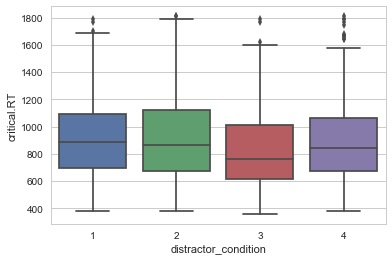

In [86]:
df = by_sentences.reset_index()
# df[['distractor_condition', 'critical.RT']].groupby(['distractor_condition']).mean().plot.bar(y='critical.RT')
sns.boxplot(x='distractor_condition', y='critical.RT', data=df)

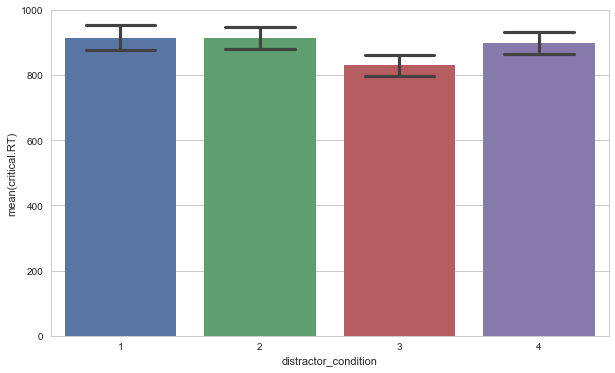

In [119]:
df = by_sentences.reset_index()
figsize(10,6)
# df[['distractor_condition', 'critical.RT']].groupby(['distractor_condition']).mean().plot.bar(y='critical.RT')
p = sns.barplot(x='distractor_condition', y='critical.RT', data=df, capsize=0.5)
fig = p.get_figure()
fig.savefig('barplot.png')

In [88]:
dfiltered = df.filter(['distractor_condition', 'critical.RT'])

groups = [dfiltered.iloc[dfiltered.groupby('distractor_condition').groups[x]]['critical.RT'] for x in range(1,5)]

f_val, p_val = stats.f_oneway(groups[0], groups[1], groups[2], groups[3])
print(f_val, p_val)

5.27828022937 0.00128466023304


In [89]:
new_cols = {}
for col in df.columns:
    if '.' in col:
        new_cols[col] = col.replace('.', '_')
        
print(new_cols)

df = df.rename(columns=new_cols)

df

{'distractor_condition.label': 'distractor_condition_label', 'critical.index': 'critical_index', 'critical.target_pos': 'critical_target_pos', 'critical.resp': 'critical_resp', 'critical.RT': 'critical_RT', 'critical.acc': 'critical_acc', 'before_critical.index': 'before_critical_index', 'before_critical.target_pos': 'before_critical_target_pos', 'before_critical.resp': 'before_critical_resp', 'before_critical.RT': 'before_critical_RT', 'before_critical.acc': 'before_critical_acc', 'after_critical.index': 'after_critical_index', 'after_critical.target_pos': 'after_critical_target_pos', 'after_critical.resp': 'after_critical_resp', 'after_critical.RT': 'after_critical_RT', 'after_critical.acc': 'after_critical_acc', 'block.acc': 'block_acc'}


,sentence_num,participant,distractor_condition,distractor_condition_label,ortho_similarity,phono_similarity,critical_index,critical_target_pos,critical_resp,critical_RT,...,before_critical_target_pos,before_critical_resp,before_critical_RT,before_critical_acc,after_critical_index,after_critical_target_pos,after_critical_resp,after_critical_RT,after_critical_acc,block_acc
0,1,101,3,phon_sim,False,True,10.0,0.0,0.0,653.42,...,0.0,0.0,694.97,1.0,11.0,1.0,1.0,989.49,1.0,1
1,1,103,1,both_sim,True,True,10.0,0.0,0.0,1686.03,...,0.0,0.0,632.85,1.0,11.0,1.0,1.0,716.26,1.0,0
2,1,107,1,both_sim,True,True,10.0,1.0,1.0,843.67,...,0.0,0.0,654.27,1.0,11.0,1.0,1.0,738.60,1.0,1
3,1,109,3,phon_sim,False,True,10.0,1.0,1.0,926.49,...,0.0,0.0,737.32,1.0,11.0,1.0,1.0,968.82,1.0,1
4,1,110,4,both_dif,False,False,10.0,0.0,0.0,1030.97,...,0.0,0.0,610.80,1.0,11.0,0.0,0.0,757.36,1.0,1
5,1,113,3,phon_sim,False,True,10.0,0.0,0.0,441.94,...,1.0,1.0,673.55,1.0,11.0,1.0,1.0,779.12,1.0,1
6,1,114,4,both_dif,False,False,10.0,1.0,1.0,843.24,...,1.0,1.0,632.74,1.0,11.0,0.0,0.0,590.37,1.0,1
7,1,117,4,both_dif,False,False,10.0,0.0,0.0,843.29,...,0.0,0.0,717.09,1.0,11.0,1.0,1.0,906.46,1.0,1
8,1,118,1,both_sim,True,True,10.0,1.0,1.0,1096.08,...,0.0,0.0,949.29,1.0,11.0,1.0,1.0,758.69,1.0,1
9,1,119,2,orth_sim,True,False,10.0,0.0,0.0,1051.79,...,1.0,1.0,589.02,1.0,11.0,0.0,0.0,716.16,1.0,1


In [100]:
model = smf.ols(
    formula=(
        'critical_RT ~ C(ortho_similarity) + C(phono_similarity) + C(ortho_similarity):C(phono_similarity)'
    ),
    data=df
).fit()

# display(model.summary())
aov_table = anova.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(ortho_similarity),6.591387e+05,1.0,7.288971,0.007038
C(phono_similarity),3.778543e+05,1.0,4.178436,0.041164
C(ortho_similarity):C(phono_similarity),3.376798e+05,1.0,3.734174,0.053551
Residual,1.060739e+08,1173.0,NaN,NaN


In [99]:
model = smf.ols(
    formula=(
        'critical_RT ~ C(ortho_similarity) + C(phono_similarity) + C(ortho_similarity):C(phono_similarity)'
        + '+ C(critical_length) + C(critical_length):C(ortho_similarity) + C(critical_length):C(phono_similarity) + C(critical_length):C(ortho_similarity):C(phono_similarity)'
    ),
    data=df
).fit()

# display(model.summary())
aov_table = anova.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(ortho_similarity),7.310423e+05,1.0,8.273397,4.096816e-03
C(phono_similarity),3.752370e+05,1.0,4.246656,3.955082e-02
C(critical_length),3.074375e+06,4.0,8.698379,6.436390e-07
C(ortho_similarity):C(phono_similarity),3.183925e+05,1.0,3.603332,5.791256e-02
C(critical_length):C(ortho_similarity),2.705352e+05,4.0,0.765429,5.477831e-01
C(critical_length):C(phono_similarity),4.565173e+05,4.0,1.291632,2.713221e-01
C(critical_length):C(ortho_similarity):C(phono_similarity),1.039958e+05,4.0,0.294237,8.818109e-01
Residual,1.022332e+08,1157.0,NaN,NaN


In [91]:
after_df = df.loc[np.isfinite(df['after_critical_RT'])]
# display(after_df)
after_model = smf.ols(
    formula='after_critical_RT ~ ortho_similarity + phono_similarity + ortho_similarity:phono_similarity',
    data=after_df
).fit()

after_aov_table = anova.anova_lm(after_model, typ=2)
after_aov_table

,sum_sq,df,F,PR(>F)
ortho_similarity,2.224390e+05,1.0,1.090340,0.296689
phono_similarity,9.075396e+04,1.0,0.444853,0.504968
ortho_similarity:phono_similarity,1.006671e+05,1.0,0.493445,0.482584
Residual,1.756515e+08,861.0,NaN,NaN


In [92]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

In [93]:
eta_squared(aov_table)
omega_squared(aov_table)
aov_table

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(ortho_similarity),6.591387e+05,1.0,7.288971,0.007038,0.006134,0.005288
C(phono_similarity),3.778543e+05,1.0,4.178436,0.041164,0.003517,0.002673
C(ortho_similarity):C(phono_similarity),3.376798e+05,1.0,3.734174,0.053551,0.003143,0.002299
Residual,1.060739e+08,1173.0,NaN,NaN,NaN,NaN


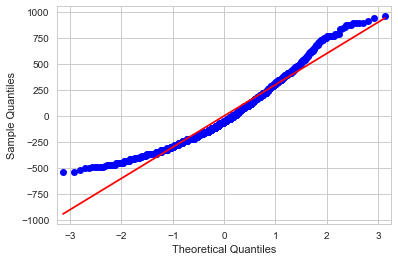

In [94]:
res = model.resid 
fig = sm.qqplot(res, line='s')
plt.show()

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


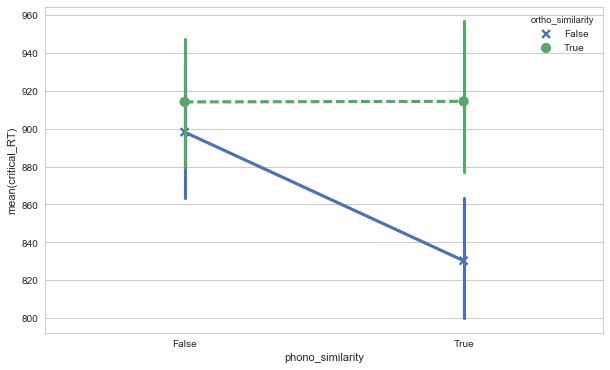

In [117]:
%matplotlib
%pylab inline
figsize(10, 6)
p = sns.pointplot(x='phono_similarity', y='critical_RT', hue='ortho_similarity',
              data=df,
#               data=df.loc[df['critical_length'] == 1],
              markers=["x", "o"],
              linestyles=["-", "--"])
fig = p.get_figure()
fig.savefig('test.png')